# Pipeline for testing models on MTS

## Introduction
This notebook is meant to be a draft for different **VAE** (Variational Autoencoder) struktures to test them on generated **MTS** (Multivariate Time Series) with varying complexity.    
It uses the **dataGen** class to simulate some artificial manufakturing Data, where all the parameters and effects (Seasonalities, Trends, Couling and Anomalies) can be controlled.   
The **Encoders** and **Decoders** classes contain the different encoding, decoding blocks to form the vae, **vae** uses combines them together to form vae.   
**train** class contains the functions to train and test the models. All other functions for plotting the results and experimenting with the Latent Representation are stored in **utils**.  

In [1]:
%load_ext autoreload
%autoreload 2
from dataGen import Gen
from utils import compare, experiment
from train import slidingWindow, criterion, criterion_tol, train, test, objective
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder
from vae import VariationalAutoencoder

import torch; torch.manual_seed(955)
import torch.optim as optim
from torch.utils.data import DataLoader
import optuna
from optuna.samplers import TPESampler


import numpy as np
import matplotlib.pyplot as plt
import pprint

## Generating the fake data

Here we specify all the parameters for the data generation.   
It is important to note that all the parameters control the shape of the data but the **MTS** is generated randomly with respect to these inputs. The actual paramters ($\mu$ and $\gamma$ at each point, indexes and values of each effect etc...) are stored in the **params** and **e_params** attributes of the class.
### Channels
- **Periode:** The number of days to simulate.
- **Step:** How many minutes between each Measurement.
- **Val:** The maximum Value possible in y-axis.
- **n_channels:** The number of channels to simulate.   

### Effects
All Effect but the **Noise** are applied on the mean and std level (internal) and not on the final values.
- **Pulse:** Can be a point or a rectangular pulse over an interval.
- **Trend:** Is basically a shift in one of the channels, can be linear or quadratic.
- **Seasonality:** Adds a sinusiudal fluctuation on a channel, the frequency here is 'how many oscillations per week'.
- **Std_variation:** Changes the std over an interval .
- **Channel_Coupling** Adds a coupling between two channels over the whole Simulation. If active, the Cov Matrix will have non-zero values beside the diagonal.
- **Noise:** Adds some noise on the generated values to simulate measurement noise &rarr; $y_{noise} = y +\epsilon $.

{'Channels_Coupling': {'amplitude': [], 'channels': []},
 'Noise': {'channel': [], 'index': [], 'slope': []},
 'Pulse': {'amplitude': [0.24996521081320866, -1.424484814746763],
           'channel': [0, 0],
           'index': ['2023-03-05T16:00:00', '2023-03-12T22:45:00']},
 'Seasonality': {'amplitude': [16, 15],
                 'channel': [0, 0],
                 'frequency_per_week': [7.027637864295401, 10.585345843700436],
                 'phaseshift': [62, 33]},
 'Std_variation': {'amplitude': [], 'channel': [], 'interval': []},
 'Trend': {'channel': [0, 0],
           'index': ['2023-03-15T08:40:00', '2023-03-09T20:30:00'],
           'slope': [0.0018535981836779727, 0.0045339334619493655]}}


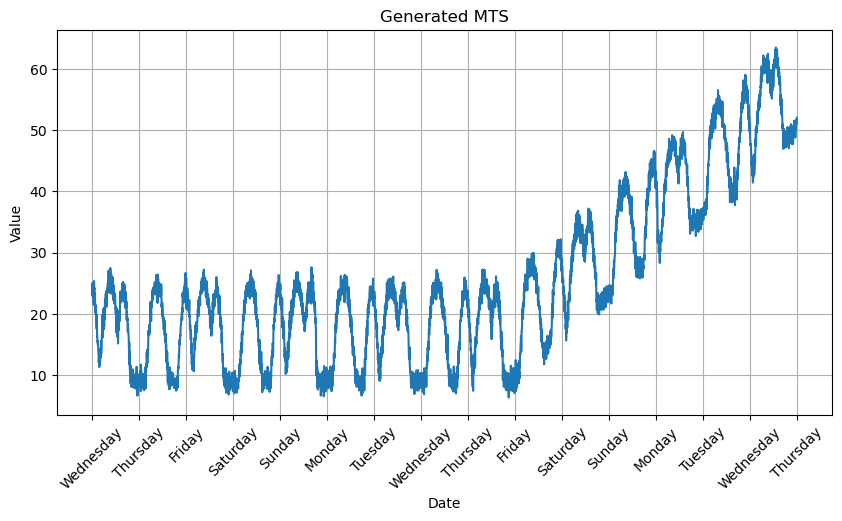

In [2]:
# all parameters for generating the time series should be configured in this cell
periode = 15 #days
step = 5 # mess interval in minutes
val = 100
n_channels = 1
effects = {
    "Pulse": {
        "occurances":2,
        "max_amplitude":1.5,   
        "interval":40
        },
    "Trend": {
        "occurances":2,
        "max_slope":0.005,
        "type":"linear"
        },
    "Seasonality": {
        "occurances":2,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":1000,
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

X = Gen(periode, step, val, n_channels, effects)
x, params, e_params = X.parameters()
# pprint.pprint(params)
pprint.pprint(e_params)
X.show()

## Model Init
The **vae** and **optimizer** are initialized in this cell.  
- **input_size** is the number of channels.
- **hidden_size** is the number of Neurons in the hidden size of the last MLP layer of the **Encoder** (to generate the $\mu$ and $\sigma$).
- **num_layer** is the number of layers in the main Structure (TCN or RNN for now).
- **latent_dims** is the number of variables in the Latent Representation.
- **v_encoder** which Encoder to use from the **Encoders** class.
- **v_decoder** which Encoder to use from the **Decoders** class.
- **L** is the window length.
- **slope** is the slope value for the LeakyRelu activation (if they are used).
- **first_kernel** is only relevant for the LongShort_TCVAE and specifies the Kernel length of the first conv layer in the long TCN.

In [3]:
### Init Model
latent_dims = 15
L = 60
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# v = vae(n_channels, L, latent_dims)
v = VariationalAutoencoder(input_size = n_channels,
                           hidden_size = 30,
                           num_layers = 3,
                           latent_dims= latent_dims,
                           v_encoder = LongShort_TCVAE_Encoder, # RnnEncoder, LongShort_TCVAE_Encoder,
                           v_decoder = LongShort_TCVAE_Decoder, # RnnDecoder, LongShort_TCVAE_Decoder,
                           L = L,
                           slope = 0.2,
                           first_kernel = 21)
opt = optim.Adam(v.parameters(), lr = 0.001571)
print(v)

VariationalAutoencoder(
  (encoder): LongShort_TCVAE_Encoder(
    (short_encoder): TCVAE_Encoder(
      (cnn_layers): ModuleList(
        (0): Conv1d(1, 2, kernel_size=(2,), stride=(2,))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv1d(2, 4, kernel_size=(2,), stride=(2,))
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Conv1d(4, 6, kernel_size=(2,), stride=(2,))
        (7): LeakyReLU(negative_slope=0.2, inplace=True)
        (8): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (encoder_mu): Sequential(
        (0): Linear(in_features=42, out_features=15, bias=True)
      )
      (encoder_logvar): Sequential(
        (0): Linear(in_features=42, out_features=15, bias=True)
      )
    )
    (long_encoder): TCVAE_

## Split and Dataloader
This cell is for splitting the Data and creating a Dataloader for each set. The dataloaders will return the data using an overlapping sliding window over the time axis.

In [4]:
# serie = torch.tensor(serie).float()
x = torch.FloatTensor(x)
n = x.shape[1]

train_ = x[:, :int(0.8*n)]
val_   = x[:, int(0.8*n):int(0.9*n)]
test_  = x[:, int(0.9*n):]

train_data = DataLoader(slidingWindow(train_, L),
                        batch_size=10,
                        shuffle = False
                        )
val_data = DataLoader(slidingWindow(val_, L),
                        batch_size=10,
                        shuffle = False
                        )
test_data = DataLoader(slidingWindow(test_, L),
                        batch_size=10,
                        shuffle = False
                        )

## Training 
The data is trained using the train class for 100 epochs. A hyperparameter optimisation can be also run (needs gpu)

In [5]:
for epoch in range(1, 40):
    train(v, train_data, criterion_tol, opt, device, epoch)
test(v, test_data, criterion_tol, device)

torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
Train Epoch: 1 [0/3396 (0%)]	Loss: 3069.722852
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.

torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Siz

torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Siz

torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Siz

torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Siz

torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Siz

torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Size([10, 42])
torch.Size([10, 6, 5])
torch.Size([10, 30])
torch.Size([10, 6, 7])
torch.Siz

KeyboardInterrupt: 

In [38]:
# Define the Optuna study and optimize the hyperparameters
epochs = 30
study = optuna.create_study(sampler=TPESampler(), direction='minimize')
study.optimize(lambda trial: objective(trial,
                                       VariationalAutoencoder,
                                       train_data, 
                                       test_data, 
                                       criterion, 
                                       train, 
                                       test, 
                                       n_channels,
                                       L, epochs
                                      ),
               n_trials=10)

[I 2023-04-02 12:04:32,007] A new study created in memory with name: no-name-b6921e1d-ab7c-4056-8a4f-813065d4ec86
/mnt/e/Master/VAE/train.py:110: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 1e-5, 1e-1)


Train Epoch: 1 [0/3396 (0%)]	Loss: 8822.587500
Train Epoch: 1 [1000/3396 (29%)]	Loss: 46.912848
Train Epoch: 1 [2000/3396 (59%)]	Loss: 865.893945
Train Epoch: 1 [3000/3396 (88%)]	Loss: 138.536975
====> Epoch: 1 Average loss: 560.9515
Train Epoch: 2 [0/3396 (0%)]	Loss: 2316.494922
Train Epoch: 2 [1000/3396 (29%)]	Loss: 28.658279
Train Epoch: 2 [2000/3396 (59%)]	Loss: 400.934937
Train Epoch: 2 [3000/3396 (88%)]	Loss: 118.014954
====> Epoch: 2 Average loss: 132.2083
Train Epoch: 3 [0/3396 (0%)]	Loss: 2481.705664
Train Epoch: 3 [1000/3396 (29%)]	Loss: 22.609171
Train Epoch: 3 [2000/3396 (59%)]	Loss: 448.475146
Train Epoch: 3 [3000/3396 (88%)]	Loss: 150.996863
====> Epoch: 3 Average loss: 127.5506
Train Epoch: 4 [0/3396 (0%)]	Loss: 2415.848828


[W 2023-04-02 12:04:37,663] Trial 0 failed with parameters: {'learning_rate': 0.08193653332426057, 'num_layers': 3, 'latent_dims': 12, 'first_kernel': 17, 'slope': 0} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/anis/mambaforge/envs/testenv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_65/175245623.py", line 4, in <lambda>
    study.optimize(lambda trial: objective(trial,
  File "/mnt/e/Master/VAE/train.py", line 133, in objective
    train_fcn(v, train_data, criterion_fcn, optimizer, device, epoch)
  File "/mnt/e/Master/VAE/train.py", line 75, in train
    x_rec, mu, logvar = model(data)
  File "/home/anis/mambaforge/envs/testenv/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/mnt/e/Master/VAE/vae.py", line 21, in forward
    mu, logvar = self.encoder(x)

KeyboardInterrupt: 

## Plot and Experiment
**compare** function plots the <span style="color:blue">Original Data</span> vs <span style="color:red">Reconstruction </span>.
**experiment** generates 2 interactive plots.
- **Left** is the same plot generated by compare (<span style="color:blue">Original Data</span> vs <span style="color:red">Reconstruction </span>)
- **Right** are the Latent Variables **Z** over time.   
The Sliders on the bottom control the values of each $z$ to see the effect it has on the reconstruction. both plots react to the change of $z$ values.

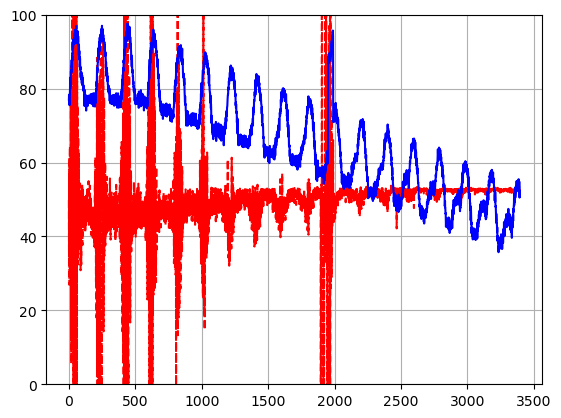

In [43]:
compare(train_data, v)

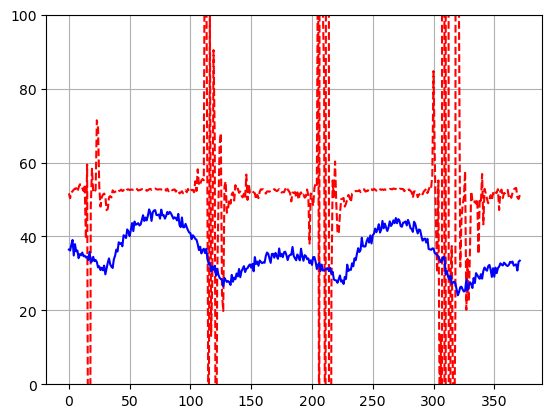

In [44]:
compare(test_data, v)

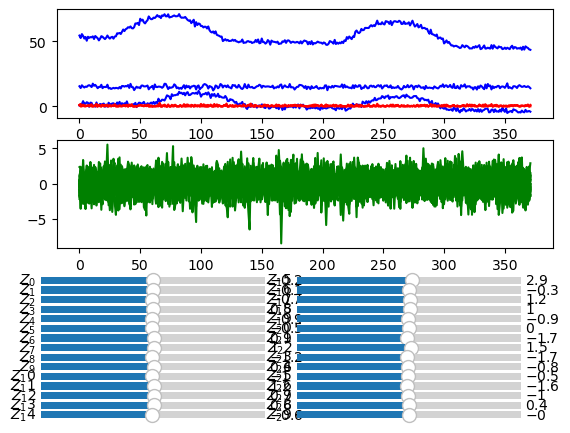

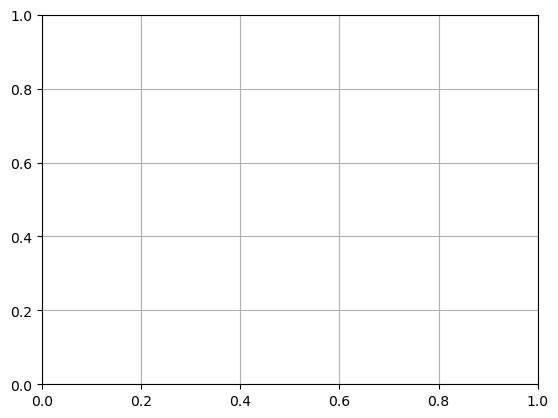

In [5]:
experiment(test_data, v)